# Week 7: OLS for non-linear relationships

## By Charlie Eaton

Note for writing formulas: here is an awesome wiki dictionary for LaTex code for math symbols: https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols

## OLS Non-linear relationships:

1. are nominal/categorical (dummy variables)

2. change in increments (sequential dummy variables)

3. change direction or strength abruptly (spline)

4. change direction gradually (quadratic)

5. accelerate/decelerate -- i.e. curve (logarithmic)

## Do the usual to check out the data

In [1]:
%set graph_format svg

In [2]:
qui set more off
qui capture log close
qui log using w7lesson_log20200304.log
qui use realrinc age sex race educ yearsjob paeduc PASEI10 using GSS2018w7.dta, clear
*describe
*summarize realrinc age sex race educ yearsjob paeduc

## 1. Nominal dummy variables

Creates "0" and "1" indicator variables for each category of a nominal variable.

Add the two nominal variables in our dataset to the code below to create dummy variables for each.

In [3]:
xi i.sex i.race, noomit

In [4]:
%head sex race _I* if _n<6

+---------------------------------------------------------------------+
      |    sex    race   _Isex_1   _Isex_2   _Irace_1   _Irace_2   _Irace_3 |
      |---------------------------------------------------------------------|
   1. |   male   white         1         0          1          0          0 |
   2. | female   white         0         1          1          0          0 |
   3. |   male   white         1         0          1          0          0 |
   4. | female   white         0         1          1          0          0 |
   5. |   male   black         1         0          0          1          0 |
      +---------------------------------------------------------------------+

### Specify which category to omit in regression

Change the number in the stub of each nominal variable below to specify omitted categories

In [6]:
xi: reg realrinc ib2.sex ib3.race


      Source |       SS           df       MS      Number of obs   =     1,363
-------------+----------------------------------   F(3, 1359)      =     25.23
       Model |  5.9937e+10         3  1.9979e+10   Prob > F        =    0.0000
    Residual |  1.0762e+12     1,359   791879153   R-squared       =    0.0528
-------------+----------------------------------   Adj R-squared   =    0.0507
       Total |  1.1361e+12     1,362   834141678   Root MSE        =     28140

------------------------------------------------------------------------------
    realrinc |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         sex |
       male  |   10329.82   1531.701     6.74   0.000     7325.067    13334.58
             |
        race |
      white  |   8999.018   2353.323     3.82   0.000     4382.478    13615.56
      black  |   305.6956   2866.753     0.11   0.915    -5318.046    5929.437
     

### A nice graphical way to represent dummy estimates is OLS adjusted means

These are the estimated mean for a category if all other variables are estimated as held constant





  Variables that uniquely identify margins: race


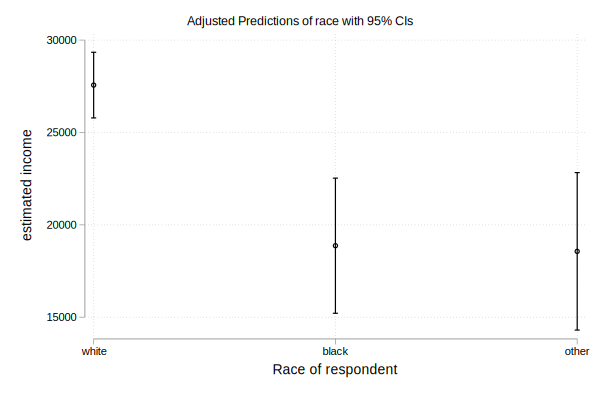

In [12]:
set scheme plotplainblind
qui margins i.race, atmeans
*marginsplot
marginsplot, unique recast(scatter) ytitle(estimated income)

## 2. Recoding continuous variables to sequential dummies

This is a good tool when interval ratio relationships change direction or slope (i.e. are non-linear)

For example, student debt (DV) and parental income (IV) have a non-linear relationship (Houle 2014):

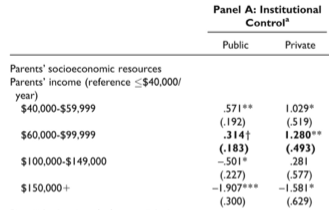

### What about modeling income (DV) and age (IV)?

### Is it linear?

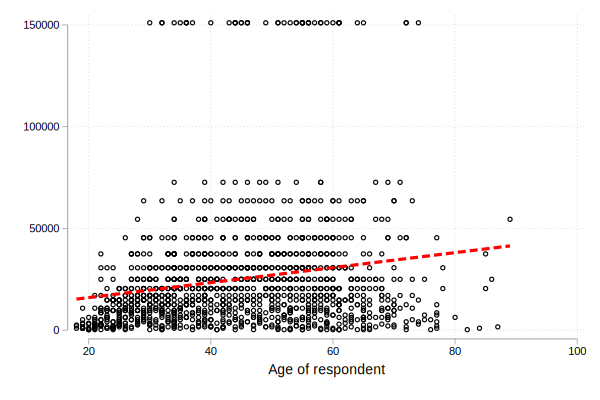

In [13]:
tw (scatter realrinc age, sort) (lfit realrinc age, color(red) ///
lwidth(thick)), legend(off) name(linear, replace)

### Convert age to sequential dummy variables to check

First, recode age as age brackets

In [22]:
*drop agecat
*egen agecat = cut(age), at(18,30,40,50,60,70,90)
sum agecat


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
      agecat |      2,341    43.74797    17.43667         18         70


### Then regress income on age categories as dummies





  Variables that uniquely identify margins: agecat


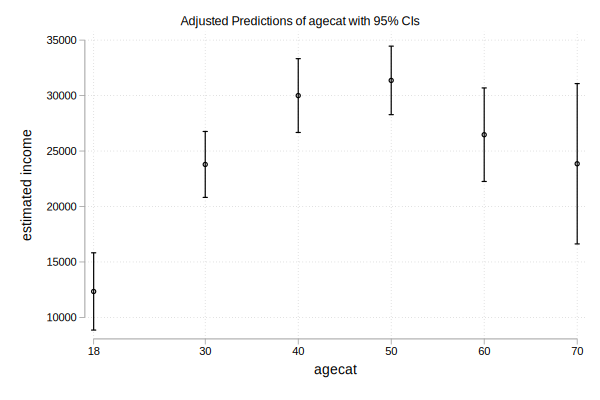

In [25]:
qui xi: reg realrinc ib18.agecat i.sex i.race
qui margins i.agecat, atmeans
marginsplot,  unique recast(scatter) ytitle(estimated income)

## 3. Splines measure slopes of interval-ratio relationships that change

*Splines measure the linear relationship for ranges of the IV.

*This enables us to test changes at discrete breaking points.

*ages1 for age-spline1 is set to the age for everyone under 50 and 50 for everyone above 50
ages2 is set to the age minus 50 for everyone above 50 and 0 for everyone else

In [27]:
*Create two spline vars with a "Knot" at age 50
mkspline ages1 50 ages2 = age

*Look at the distribution of values for the two spline vars with histogram
*histogram ages1, name(hist1)
*histogram ages2, name(hist2)

variable ages1 already defined


r(110);




      Source |       SS           df       MS      Number of obs   =     1,358
-------------+----------------------------------   F(2, 1355)      =     45.15
       Model |  7.0926e+10         2  3.5463e+10   Prob > F        =    0.0000
    Residual |  1.0643e+12     1,355   785433845   R-squared       =    0.0625
-------------+----------------------------------   Adj R-squared   =    0.0611
       Total |  1.1352e+12     1,357   836543033   Root MSE        =     28026

------------------------------------------------------------------------------
    realrinc |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
       ages1 |   866.8012   93.33994     9.29   0.000     683.6947    1049.908
       ages2 |  -463.5205   138.6246    -3.34   0.001    -735.4627   -191.5784
       _cons |  -8611.677    3631.31    -2.37   0.018    -15735.28   -1488.077
-------------------------------------------------

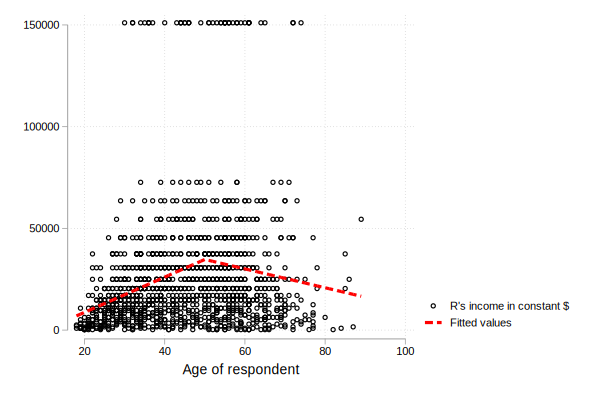

In [28]:
*OLS estimate the slope for age above and below 50 and predict y values
regress realrinc ages1 ages2
predict yhat

*Graph the fited spline lines for ages above and below 50
tw (scatter realrinc age) (line yhat age, sort color(red) lwidth(thick))

## 4. Quadratics: when interval ratio relationships gradually change direction

* For example the relationship between income (DV) and age (IV)
* The solution is to square the IV (age) and add it to the model:

$ \hat{Y} = \alpha + \beta_1 \cdot X + \beta_2 \cdot X^2 $

### Let's compare age coefficients with and w/o a quadratic

Complete the code below to create a squared age variable

In [29]:
qui est clear

*Model 1 - no quadritic
qui eststo: regress realrinc age

*Model 2 - quadratic added
gen age2=age^2

qui eststo: regress realrinc age age2

**Print a table with the two models
esttab, stats(r2 N, labels("R-Sqaured" "N")) cells(b(star fmt(3)) ///
se(fmt(3) par)) nobase




(7 missing values generated)



--------------------------------------------
                      (1)             (2)   
                 realrinc        realrinc   
                     b/se            b/se   
--------------------------------------------
age               368.137***     2485.627***
                 (53.864)       (316.065)   
age2                              -22.874***
                                  (3.366)   
_cons            8620.324***   -35611.186***
               (2516.285)      (6963.553)   
--------------------------------------------
R-Sqaured           0.033           0.065   
N                1358.000        1358.000   
--------------------------------------------


### Also graph the quadratic and compare

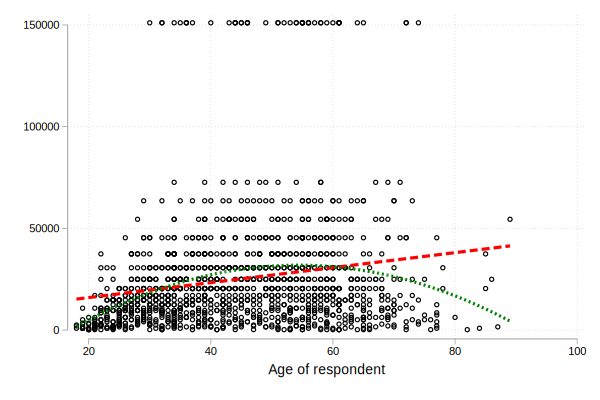

In [34]:
tw (scatter realrinc age, sort) ///
(lfit realrinc age, color(red) lwidth(thick)) ///
(qfit realrinc age, color(green) lwidth(thick)), ///
legend(off) name(quadratic, replace)

## 5. Logarithms: model when interval ratio relationships accelerate/decelerate (curve)

### You can log dependent or independent

*Some relationships curve, like with income (DV) and education/human capital investment (IV)

*Logs are the opposites of exponents like $X^3$

*Definition of (natural) logarithm: The exponent to which a another number (e=2.718... for natural logs) must be raised to produce X, Y, or any other given number. (e=2.718... is an irrational and transcendental number like $\pi$)

$Z = ln(X)$ if $X = 2.718^Z$

*When graphed, the natural log function looks like this:

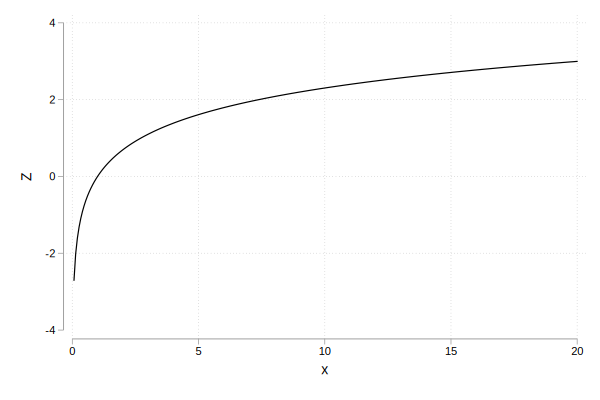

In [35]:
tw (function Z = log(x), range(0 20))

**When X is less than 1 (like ..5), Z is negative

We can reverse engineer this:

In [40]:
display "if Z=-2, X = 2.718^Z = 2.718^-2 = 1/2.718 * 1/2.718 = " 1/2.718 * 1/2.718
display "if X=.135, Z= ln(X) = ln(.135) = "log(.135)

display "if Z=2, X = 2.718^Z = 2.718^2 =  "= 2.718^2
display "if X=[??], Z= ln(X) = ln([??]) =" log(7.387524)


if Z=-2, X = 2.718^Z = 2.718^-2 = 1/2.718 * 1/2.718 = .13536335

if X=.135, Z= ln(X) = ln(.135) = -2.0024805

if Z=2, X = 2.718^Z = 2.718^2 =  7.387524

if X=[??], Z= ln(X) = ln([??]) =1.9997926


### A magical feature of logs:

Logs approximate proportional change in the number that is logged for proportional chances less than .2 (20%).

For example:

In [41]:
display "e^b = Proportional Change in X = X2/X1 = (110/100) = " 110/100
display "beta = ln(e^b) = nl(X2/X1) = nl(110/100) = " = log(11/10)


e^b = Proportional Change in X = X2/X1 = (110/100) = 1.1

beta = ln(e^b) = nl(X2/X1) = nl(110/100) = .09531018


### Let's apply this to income (DV) and education (IV)

*First, create a new variable that logs income

*Then regress the unlogged and logged income variable (DV) on education (IV) and compare

*Which estimates are better and why? What is the proportional increase for income for every year of education?

In [46]:
**Create a logged income variable
*gen realrinc_ln=log(realrinc)
drop yhat yhatln
qui est clear

**Regress w/o logging
qui eststo: reg realrinc educ

** Predict Y-hat based on the above regression
qui predict yhat, xb

**Regress logged Y on education
qui eststo: reg realrinc_ln educ

** Predict logged Y-hat based on the above regression
predict yhatln







(option xb assumed; fitted values)
(3 missing values generated)


In [48]:
%head realrinc yhat yhatln educ if _n<6

+---------------------------------------+
      | realrinc       yhat     yhatln   educ |
      |---------------------------------------|
   1. |      IAP   24592.95   9.537351     14 |
   2. |      IAP   12107.58   8.953649     10 |
   3. |    45400   30835.63   9.829202     16 |
   4. |    54480   30835.63   9.829202     16 |
   5. |      IAP   37078.31   10.12105     18 |
      +---------------------------------------+

In [49]:
**Then exponentiate 
replace yhatln=2.718^(yhatln)

**Print estimates from both models
esttab, stats(r2 N, labels("R-Sqaured" "N")) cells(b(star fmt(3)) ///
se(fmt(3) par)) nobase


(2,345 real changes made)


--------------------------------------------
                      (1)             (2)   
                 realrinc     realrinc_ln   
                     b/se            b/se   
--------------------------------------------
educ             3121.341***        0.146***
                (261.385)         (0.011)   
_cons          -19105.831***        7.494***
               (3768.318)         (0.160)   
--------------------------------------------
R-Sqaured           0.095           0.113   
N                1362.000        1362.000   
--------------------------------------------


### The logged results can be more intuitive when graphed

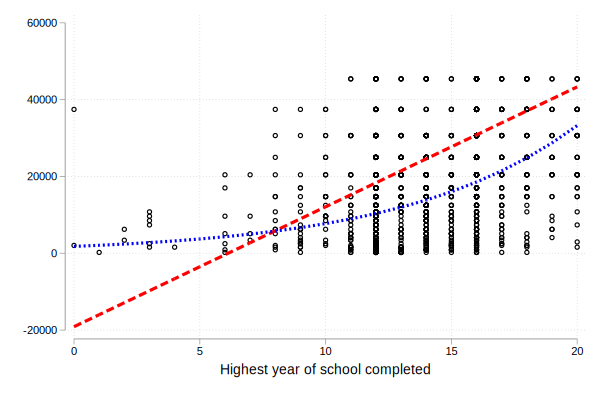

In [52]:
**Create a scatterplot of income and education
**with fitted linear regression line and fitted logged regression line
tw (scatter realrinc educ if realrinc<50000) ///
(line yhat educ, sort color(red) lwidth(thick)) ///
(line yhatln educ, sort color(blue) lwidth(thick)), legend(off)

You may want to run correlation analysis to see the linear relationship among variables